# Homework5  
# Wednesday
# Junxuan Fu 4269007374
# Yueran Ma 1952189989
# Ada Zhong 7075205876

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
combine = [train, test]

In [5]:
train[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
for data in combine:
    data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [7]:
for data in combine:
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [8]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for data in combine:
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [9]:
train = train.drop(['Name', 'PassengerId','Ticket', 'Cabin'], axis=1)
test = test.drop(['Name','Ticket', 'Cabin'], axis=1)
combine = [train, test]
train[:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,3
2,1,3,female,26.0,0,0,7.9250,S,2
3,1,1,female,35.0,1,0,53.1000,S,3
4,0,3,male,35.0,0,0,8.0500,S,1


In [10]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


In [11]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [12]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [13]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


In [14]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean(
).sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [15]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [16]:
train = train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test = test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train, test]

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [17]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [18]:
freq_port = train.Embarked.dropna().mode()[0]
freq_port

'S'

In [19]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean(
).sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [20]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


In [21]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [22]:
train['FareBand'] = pd.qcut(train['Fare'], 4)
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean(
).sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [23]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train = train.drop(['FareBand'], axis=1)
combine = [train, test]
    
train.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


2.Fit an Extreme Gradient Boosting model and report the test accuracy rate and the auc. Plot the ROC curve for the test set.

In [24]:
X = train.drop(['Survived'],axis = 1)
y = train.Survived

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.5,
                                                test_size = 0.50,random_state=1)

In [26]:
X_test.shape

(446, 8)

In [27]:
y_test.shape

(446,)

In [28]:
xgboost = XGBClassifier(n_estimators = 100, learning_rate = 0.1)
xgboost.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [29]:
predictions = xgboost.predict(X_test)
accuracy = accuracy_score(y_test,predictions)
accuracy

0.7937219730941704

In [30]:
# test accuracy rate is 0.7937

In [31]:
y_pro = xgboost.predict_proba(X_test)[:, 1]

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pro)

In [33]:
roc_auc = auc(fpr, tpr)
roc_auc

0.8450622285939869

In [34]:
# the auc is 0.8451

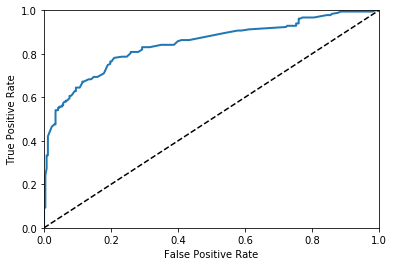

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

3.Rather than picking the model that produced the best results against the training set, why not use them all and let them vote? That is, form a solution matrix from the columns produced by each of the 9 models. Produce a new column which is the sum of each row. Thus, the value of this column will be a number between 0 and n, which is the number of the n models that voted yes on whether that person survived. Go with the votes - if more than half survived, vote yes, that is 1, otherwise vote no, that is 0. Use the result of your voting model to determine the success of this method.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [38]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [39]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred_logreg = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


80.36

In [40]:
coeff_df = pd.DataFrame(train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201527
5,Title,0.398234
2,Age,0.287164
4,Embarked,0.261762
6,IsAlone,0.129140
3,Fare,-0.085150
7,Age*Class,-0.311199
0,Pclass,-0.749006


In [41]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred_svc = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


83.84

In [42]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.74

In [43]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_gaussian = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

72.28

In [44]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred_percep = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

78.34

In [45]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred_linear_svc = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


79.12

In [46]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred_sgd = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

71.83

In [47]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_decision_tree = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76

In [48]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_random_forest = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.76

In [49]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.76
8,Decision Tree,86.76
1,KNN,84.74
0,Support Vector Machines,83.84
2,Logistic Regression,80.36
7,Linear SVC,79.12
5,Perceptron,78.34
4,Naive Bayes,72.28
6,Stochastic Gradient Decent,71.83


In [50]:
sol_matrix = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived_random_forest": Y_pred_random_forest,
        "Survived_Decision_Tree": Y_pred_decision_tree,
        "Survived_KNN": Y_pred_knn,
        "Survived_SVM": Y_pred_svc,
        "Survived_Logreg": Y_pred_logreg,
        "Survived_linear_svc": Y_pred_linear_svc,
        "Survived_Perceptron": Y_pred_percep,
        "Survived_Gaussian": Y_pred_gaussian,
        "Survived_SGD": Y_pred_sgd
    })

In [51]:
sol_matrix.iloc[:5,-5:]

,Survived_Logreg,Survived_linear_svc,Survived_Perceptron,Survived_Gaussian,Survived_SGD
0,0,0,0,0,0
1,0,1,0,1,0
2,0,0,0,0,0
3,0,0,0,0,0
4,1,1,0,1,0


In [52]:
sol_matrix['Survived'] = sol_matrix.Survived_random_forest + sol_matrix.Survived_Decision_Tree \
+ sol_matrix.Survived_KNN + sol_matrix.Survived_SVM + sol_matrix.Survived_Logreg \
+ sol_matrix.Survived_linear_svc + sol_matrix.Survived_Perceptron \
+ sol_matrix.Survived_Gaussian + sol_matrix.Survived_SGD
    
sol_matrix.iloc[:5,-5:]

,Survived_linear_svc,Survived_Perceptron,Survived_Gaussian,Survived_SGD,Survived
0,0,0,0,0,0
1,1,0,1,0,2
2,0,0,0,0,0
3,0,0,0,0,0
4,1,0,1,0,6


In [53]:
sol_matrix['Vote'] = sol_matrix.Survived

In [54]:
sol_matrix.loc[sol_matrix['Vote'] < 4.5, 'Vote'] = 0
sol_matrix.loc[sol_matrix['Vote'] > 4.5, 'Vote'] = 1
sol_matrix.iloc[:5,-5:]

,Survived_Perceptron,Survived_Gaussian,Survived_SGD,Survived,Vote
0,0,0,0,0,0
1,0,1,0,2,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,1,0,6,1


In [55]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": sol_matrix["Vote"]
    })

submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [56]:
submission.to_csv('submission.csv', index=False)

4.Experiment again by dropping the model which scored the worst. Or perhaps drop the two worst, because with an odd number of columns, and 0’s or 1’s as outputs, there will not be a tie. Report the new score (accuracy rate).

In [57]:
sol_matrix1 = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived_random_forest": Y_pred_random_forest,
        "Survived_Decision_Tree": Y_pred_decision_tree,
        "Survived_KNN": Y_pred_knn,
        "Survived_SVM": Y_pred_svc,
        "Survived_Logreg": Y_pred_logreg,
        "Survived_linear_svc": Y_pred_linear_svc,
        "Survived_Perceptron": Y_pred_percep,
    })

In [58]:
sol_matrix1.iloc[:5,-5:]

,Survived_KNN,Survived_SVM,Survived_Logreg,Survived_linear_svc,Survived_Perceptron
0,0,0,0,0,0
1,0,0,0,1,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,1,1,1,0


In [59]:
sol_matrix1['Survived'] = sol_matrix1.Survived_random_forest + sol_matrix1.Survived_Decision_Tree \
+ sol_matrix1.Survived_KNN + sol_matrix1.Survived_SVM + sol_matrix1.Survived_Logreg \
+ sol_matrix1.Survived_linear_svc + sol_matrix1.Survived_Perceptron
    
sol_matrix1.iloc[:5,-5:]

,Survived_SVM,Survived_Logreg,Survived_linear_svc,Survived_Perceptron,Survived
0,0,0,0,0,0
1,0,0,1,0,1
2,0,0,0,0,0
3,0,0,0,0,0
4,1,1,1,0,5


In [60]:
sol_matrix1['Vote'] = sol_matrix1.Survived

In [61]:
sol_matrix1.loc[sol_matrix1['Vote'] < 3.5, 'Vote'] = 0
sol_matrix1.loc[sol_matrix1['Vote'] > 3.5, 'Vote'] = 1
sol_matrix1.iloc[:5,-5:]

,Survived_Logreg,Survived_linear_svc,Survived_Perceptron,Survived,Vote
0,0,0,0,0,0
1,0,1,0,1,0
2,0,0,0,0,0
3,0,0,0,0,0
4,1,1,0,5,1


In [62]:
Vote = sol_matrix1.Vote

In [63]:
# accuracy rate Logistic Regression
acc_log1 = round(logreg.score(X_test, Vote) * 100, 2)
acc_log1

91.63

In [64]:
# accuracy rate svc
acc_svc1 = round(svc.score(X_test, Vote) * 100, 2)
acc_svc1

96.41

In [65]:
# accuracy rate KNN
acc_knn1 = round(knn.score(X_test, Vote) * 100, 2)
acc_knn1

93.06

In [66]:
# accuracy rate Decision Tree
acc_decision_tree1 = round(decision_tree.score(X_test, Vote) * 100, 2)
acc_decision_tree1

92.34

In [67]:
# accuracy rate random forest
acc_random_forest1 = round(random_forest.score(X_test, Vote) * 100, 2)
acc_random_forest1

93.54

In [68]:
# accuracy rate linear SVC
acc_linear_svc1 = round(linear_svc.score(X_test, Vote) * 100, 2)
acc_linear_svc1

90.43

In [69]:
# accuracy rate perceptron
acc_perceptron1 = round(perceptron.score(X_test, Vote) * 100, 2)
acc_perceptron1

90.91

5.Submit, what you think is the best of your predictions, on to Kaggle and report the Team Name, the Score provided by Kaggle, and the date submitted to Kaggle. Feel free to ask our TA for help on how to submit to Kaggle.

In [70]:
import xgboost as xgb

In [71]:
X = train.drop(['Survived'],axis = 1)
y = train.Survived

In [72]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.5,
                                                test_size = 0.50,random_state=1)

In [73]:
xgboost = XGBClassifier(n_estimators = 100, learning_rate = 0.1)
xgboost.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [74]:
predictions = xgboost.predict(X_test)
accuracy = accuracy_score(y_test,predictions)
accuracy

0.7937219730941704

In [75]:
param_test = {
 'n_estimators':range(20,500,20),
 'learning_rate':[0.01,0.1,0.2]}
gs = GridSearchCV(estimator = xgboost, 
                  param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': range(20, 500, 20)},
             pre_dispatch='2*n_jobs', refit=True,

In [76]:
gs.best_score_, gs.best_params_

(0.8761751676411219, {'learning_rate': 0.1, 'n_estimators': 120})

In [77]:
xgboost1 = XGBClassifier(n_estimators=120,learning_rate = 0.1, max_depth=5, subsample=0.8, 
                         colsample_bytree=0.8,nthread=4)
xgboost1.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [78]:
predictions = xgboost1.predict(X_test)
accuracy = accuracy_score(y_test,predictions)
accuracy

0.7959641255605381

In [79]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)}
grid1 = GridSearchCV(estimator = xgboost1, 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid1.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=120, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, ret

In [80]:
grid1.best_score_, grid1.best_params_

(0.8732685326006967, {'max_depth': 7, 'min_child_weight': 5})

In [81]:
param_test2 = {
 'max_depth':[6,7,8],
 'min_child_weight':[4,5,6]}
grid2 = GridSearchCV(estimator = xgboost1, 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid2.fit(X,y)
grid2.best_score_, grid2.best_params_

(0.8732685326006967, {'max_depth': 7, 'min_child_weight': 5})

In [82]:
param_test3 = {'gamma':[i/10.0 for i in range(0,5)]}
grid3 = GridSearchCV(estimator = xgboost1, 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid3.fit(X,y)
grid3.best_score_, grid3.best_params_

(0.8702650315302536, {'gamma': 0.2})

In [83]:
xgboost2 = XGBClassifier(max_depth=7, subsample=0.8, 
                         min_child_weight=5, gamma=0.2, colsample_bytree=0.8,nthread=4)
xgboost2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [84]:
predictions = xgboost2.predict(X_test)
accuracy = accuracy_score(y_test,predictions)
accuracy

0.8026905829596412

In [85]:
param_test3b = {
 'n_estimators':range(20,500,20),
 'learning_rate':[0.01,0.1,0.2]}
gs = GridSearchCV(estimator = xgboost2, 
                  param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=7, min_child_weight=5,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': range(20, 500, 20)},
             pre_dispatch='2*n_jobs', refit=Tr

In [86]:
gs.best_score_, gs.best_params_

(0.8749675791918101, {'learning_rate': 0.2, 'n_estimators': 80})

In [87]:
xgboost2 = XGBClassifier(n_estimators=80, learning_rate=0.2, max_depth=7, subsample=0.8, 
                         min_child_weight=5, gamma=0.2, colsample_bytree=0.8,nthread=4)
xgboost2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=80, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [88]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grid4 = GridSearchCV(estimator = xgboost2, 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid4.fit(X,y)
grid4.best_score_, grid4.best_params_

(0.8753730783752017, {'colsample_bytree': 0.9, 'subsample': 0.7})

In [89]:
param_test4b = {
 'subsample':[i/100.0 for i in range(65,80,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}
grid4b = GridSearchCV(estimator = xgboost2, 
 param_grid = param_test4b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid4b.fit(X,y)
grid4b.best_score_, grid4b.best_params_

(0.8769225331282747, {'colsample_bytree': 0.85, 'subsample': 0.75})

In [90]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
grid5 = GridSearchCV(estimator = xgboost2, 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grid5.fit(X,y)
grid5.best_score_, grid5.best_params_

(0.8749675791918101, {'reg_alpha': 1e-05})

In [91]:
xgboost3 = XGBClassifier(n_estimators=80,learning_rate = 0.2, max_depth=7, subsample=0.75, 
                         min_child_weight=5, gamma=0.2, colsample_bytree=0.85, nthread=4,
                         reg_alpha=0.00001)
xgboost3.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0.2,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=80, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.75, verbosity=1)

In [92]:
predictions = xgboost3.predict(X_test)
accuracy = accuracy_score(y_test,predictions)
accuracy

0.804932735426009

In [93]:
X_test  = test.drop("PassengerId", axis=1).copy()

In [94]:
predic = xgboost3.predict(X_test)

In [95]:
matrix = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived_random_forest": Y_pred_random_forest,
        "Survived_Decision_Tree": Y_pred_decision_tree,
        "Survived_KNN": Y_pred_knn,
        "Survived_SVM": Y_pred_svc,
        "Survived_Logreg": Y_pred_logreg,
        "Survived_linear_svc": Y_pred_linear_svc,
        "Survived_xgb": predic,
        "Survived_Perceptron": Y_pred_percep,
        "Survived_SGD": Y_pred_sgd
    })

In [96]:
matrix['Survived'] = matrix.Survived_random_forest + matrix.Survived_Decision_Tree \
+ matrix.Survived_KNN + matrix.Survived_SVM + matrix.Survived_Logreg \
+ matrix.Survived_linear_svc + matrix.Survived_xgb \
+ matrix.Survived_Perceptron + matrix.Survived_SGD

matrix.iloc[:5,-5:]

,Survived_linear_svc,Survived_xgb,Survived_Perceptron,Survived_SGD,Survived
0,0,0,0,0,0
1,1,0,0,0,1
2,0,0,0,0,0
3,0,0,0,0,0
4,1,0,0,0,5


In [97]:
matrix['Vote'] = matrix.Survived

In [98]:
matrix.loc[matrix['Vote'] < 4.5, 'Vote'] = 0
matrix.loc[matrix['Vote'] > 4.5, 'Vote'] = 1
matrix.iloc[:5,-5:]

,Survived_xgb,Survived_Perceptron,Survived_SGD,Survived,Vote
0,0,0,0,0,0
1,0,0,0,1,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,5,1


In [99]:
submission6 = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": matrix["Vote"]
    })

submission6.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [100]:
submission6.to_csv('submission6.csv', index=False)

In [101]:
# team name : 529_MZF 
# Date submitted: 11/20/2019
# score : 0.79904